# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

# Indice

1. [Introducción](#titulo_principal)
2. [Preparación de datos](#titulo_principal_1)
3. [Entrenamiento de modelos](#titulo_principal_2)
4. [Prueba de cordura](#titulo_principal_3)
5. [Analisis de modelo](#titulo_principal_4)
6. [Conclusiones](#titulo_principal_5)
7. [Lista de control](#titulo_principal_6)

## Introducción<a id="titulo_principal"></a>

In [26]:
# Manipulación de datos
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Evaluación del rendimiento
from sklearn.metrics import mean_squared_error

# Remuestreo de datos
from pandas.tseries.frequencies import to_offset

# Desactivación de advertencias
import warnings
warnings.filterwarnings("ignore")


## Preparación de datos<a id="titulo_principal_1"></a>

In [11]:
# Carga del dataset
df =  pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [12]:
df = df.resample('H').sum()

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Los datos se muestran cada 10 minutos junto con el número de ordenes en esa temporalidad originalmente, en el anterior codigo se hizo un resample para que este el numero de ordenes por hora

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Veo en general datos limpios, hay que cambiar la columna datetime a tipo date para que sea compatible con la libreria pandas para la manipulación por zonas temporales, esto ya se hizo prevaiemente al cargar el dataset

In [10]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Se observan algunos datos bastante grandes, el 75% de los datos se encuentran por de bajo de 19 ordenes y la media es de 14 ordenes por cada 10 minutos

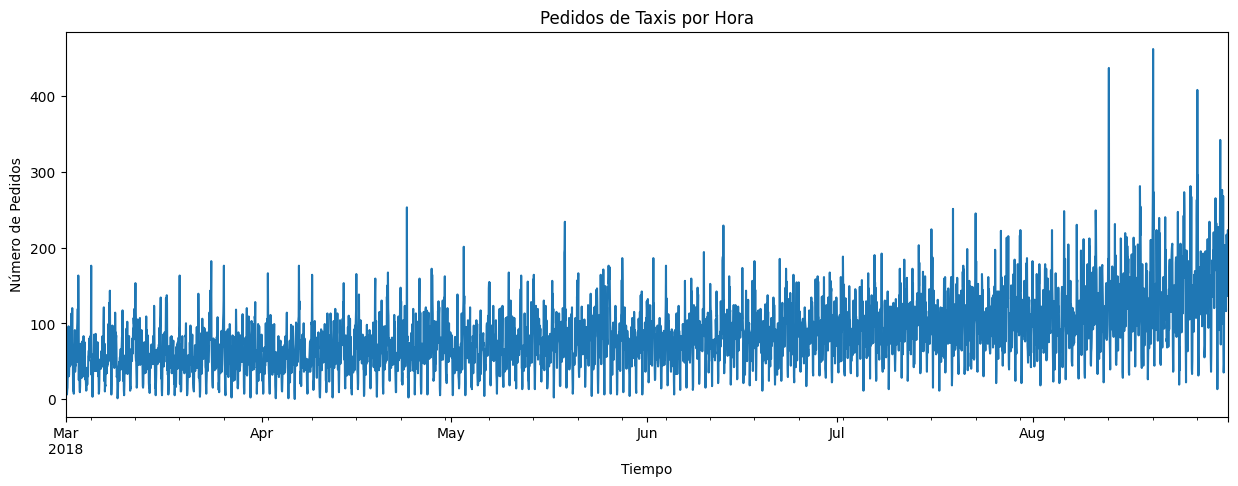

In [22]:
# Graficar la serie temporal de pedidos por hora
df['num_orders'].plot(figsize=(15, 5), title='Pedidos de Taxis por Hora')
plt.xlabel('Tiempo')
plt.ylabel('Número de Pedidos')
plt.show()

In [31]:
print(min_date)
print(max_date)

2018-03-01 00:00:00
2018-08-31 23:00:00


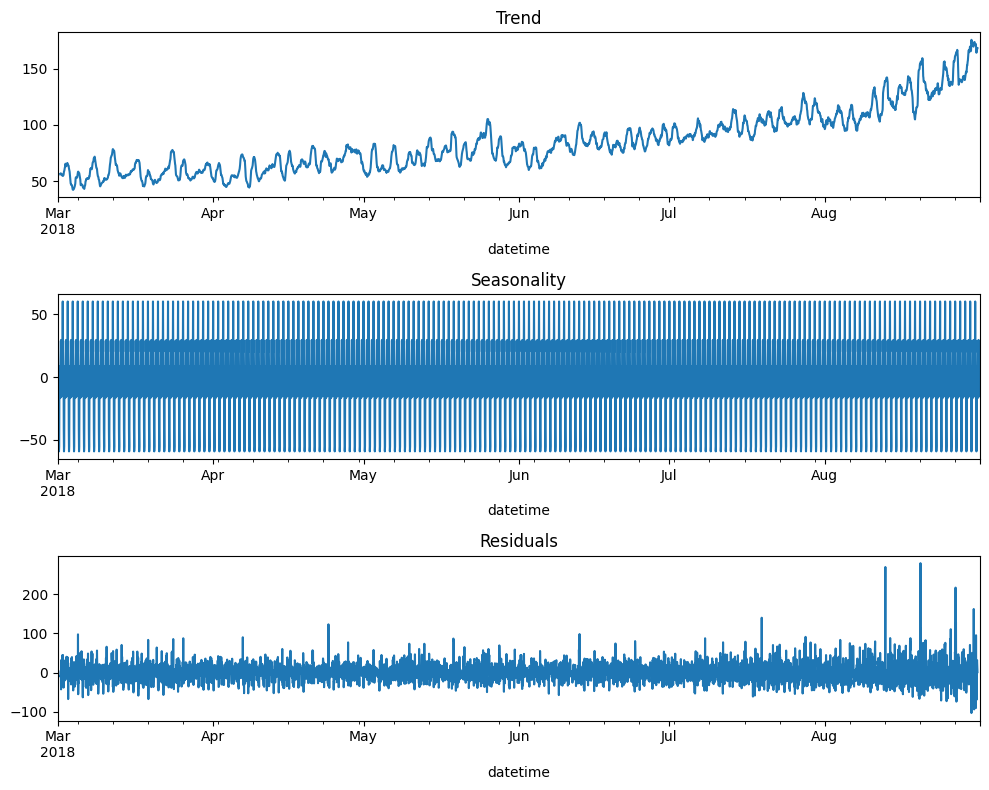

In [30]:
decomposed = seasonal_decompose(df['num_orders'], model='additive')

# Graficar las componentes
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Estacionalidad
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# Residuos
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Por lo que se puede observar en los graficos anteriores existe una tendencia alcista del numero de pedidos del servicio de taxis haciendo esta descomposición con seasonal_descompose.

A continuación analizare los pedidos del servicio por mes

<Axes: xlabel='datetime'>

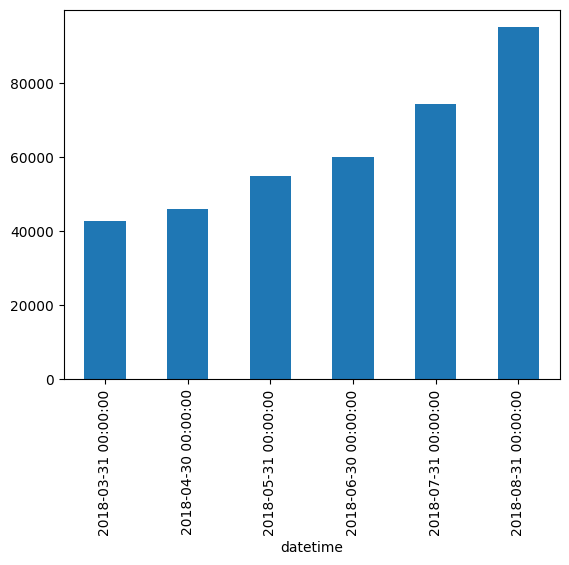

In [36]:
volume_per_month = df['num_orders'].resample('M').sum()

volume_per_month.plot(kind='bar')

En efecto se denota una tencia al alza desde el comienzo de los datos a finales de marzo hasta finales de Agosto

A continuación observare el número dee pedidos por día de la semana.

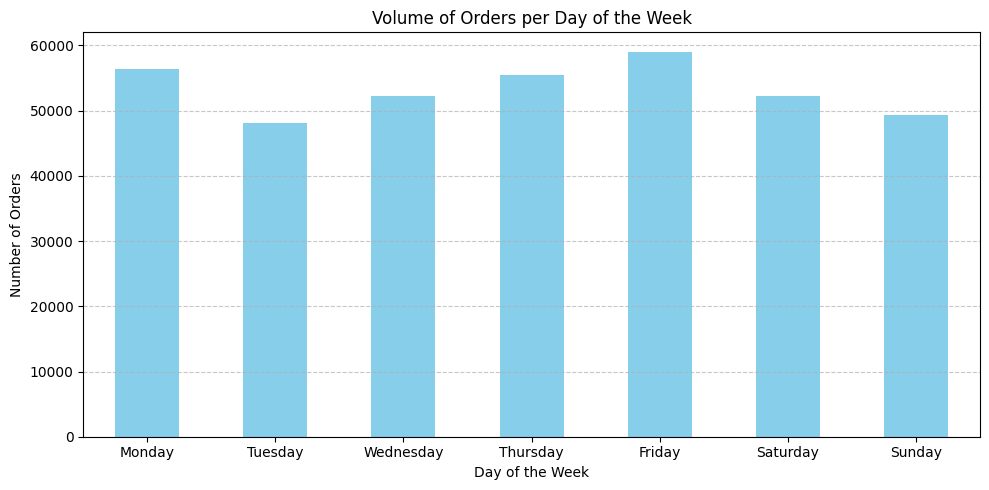

In [40]:
df_dayofweek = df.copy()

df_dayofweek['dayofweek'] = df.index.dayofweek

volume_per_dayofweek= df_dayofweek.groupby('dayofweek')['num_orders'].sum()

plt.figure(figsize=(10, 5))
volume_per_dayofweek.plot(kind='bar', color='skyblue')
plt.title('Volume of Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Los días con mayor demanda son Lunes y Viernes, parece que el día martes cae abruptamente la demanda, esta comienza a ascender tendencialmente hasta el dia Viernes para llegar a su pico y posteriormente descender hasta el día domingo 